In [1]:
import numpy as np
import seaborn as sns

sns.set(style='darkgrid', palette='viridis')

In [2]:
mass = np.load('../out/mass.npy',allow_pickle='TRUE').item()

In [5]:
mass['cell_mass']

[1170.3970356705986,
 1170.396918050392,
 1170.5373653389008,
 1170.7805377564316,
 1171.1392587363193,
 1171.5696500038694,
 1172.068014835536,
 1172.6069305668764,
 1173.1694682725326,
 1173.7534145088741,
 1174.3892070403308,
 1175.0539165133555,
 1175.726155062479,
 1176.420702081395,
 1177.1130750495051,
 1177.7967001384716,
 1178.5136527927727,
 1179.219487208307,
 1179.9324577506832,
 1180.6468376590162,
 1181.3790712724117,
 1182.1318051676935,
 1182.8837186961146,
 1183.6389546256646,
 1184.4004679928498,
 1185.172692256832,
 1185.9479430745728,
 1186.7288778783766,
 1187.5196082845473,
 1188.3122219198353,
 1189.102145319872,
 1189.8829468946694,
 1190.6774794629537,
 1191.4832397414013,
 1192.2766063779097,
 1193.0883060004637,
 1193.8875598395718,
 1194.702795187387,
 1195.5385715657958,
 1196.3688491057878,
 1197.1977519256036,
 1198.0248465573952,
 1198.8892935101048,
 1199.7540672910484,
 1200.6204769945293,
 1201.48424059087,
 1202.3554738560222,
 1203.2151451363973,
 1

<AxesSubplot:>

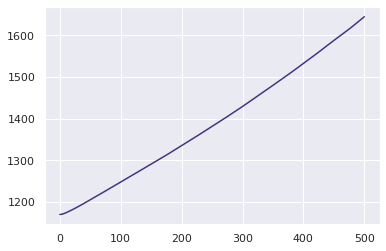

In [8]:
sns.lineplot(x=[i for i in range(len(mass['cell_mass']))],y=mass['cell_mass'])

In [1]:
import sys
if "../" not in sys.path:
    sys.path.insert(0, "../")

import numpy as np
import json

# I just ctrl-C'd the whole function in here to quickly experiment on it. Comments in the solve part.

In [2]:
"""FBA via gradient descent."""
import abc
import time
from dataclasses import dataclass
from typing import Any, Iterable, Iterator, Mapping, Optional, Tuple, Union

import jax
import jax.ops
import jax.numpy as jnp
import numpy as np
import scipy.optimize
from scipy.sparse import csr_matrix

ArrayT = Union[np.ndarray, jnp.ndarray]


class ReactionNetwork:
    """General representation of a network of stoichiometric reactions."""

    def __init__(self, reactions: Optional[Iterable[dict]] = None):
        """Initialize this reaction network.

        Args:
            reactions: a list of reaction dicts following the knowledge base structure. Expected keys are "reaction id",
                "stoichiometry", "is reversible".
        """

        # Defer construction of the stoichiometry matrix until it is needed.
        self._s_matrix = None

        # Build maps between string id and numerical array index, for reactions and molecules.
        self._reactions = {}
        self._reaction_ids = []
        self._reaction_index = {}
        self._molecule_ids = []
        self._molecule_index = {}
        if reactions is not None:
            for reaction in reactions:
                self.add_reaction(reaction)

    def add_reaction(self, reaction: dict):
        """Adds a reaction to the network.

        Args:
            reaction: a reaction dict following the knowledge base structure. Expected keys are "reaction id",
                "stoichiometry", "is reversible".
        """
        reaction_id = reaction["reaction id"]
        stoichiometry = reaction["stoichiometry"]

        self._reactions[reaction_id] = stoichiometry
        self._reaction_index[reaction_id] = len(self._reaction_ids)
        self._reaction_ids.append(reaction_id)
        for molecule_id in stoichiometry:
            if molecule_id not in self._molecule_index:
                self._molecule_index[molecule_id] = len(self._molecule_ids)
                self._molecule_ids.append(molecule_id)
        # Force reconstruction of the stoichiometry matrix.
        self._s_matrix = None

    @property
    def s_matrix(self) -> np.ndarray:
        """The 2D stoichiometry matrix describing this reaction network."""
        if self._s_matrix is None:
            s_matrix = np.zeros(self.shape)
            for reaction_id, stoichiometry in self._reactions.items():
                for molecule_id, coeff in stoichiometry.items():
                    s_matrix[self._molecule_index[molecule_id], self._reaction_index[reaction_id]] += coeff
            self._s_matrix = s_matrix
        return self._s_matrix

    @property
    def shape(self) -> Tuple[int, int]:
        """The 2D shape of this network, (#molecules, #reactions)."""
        return len(self._molecule_ids), len(self._reaction_ids)

    def reaction_ids(self) -> Iterator[str]:
        """Iterates through reaction_ids in their indexed order."""
        for reaction_id in self._reaction_ids:
            yield reaction_id

    def reaction_index(self, reaction_id: str) -> Optional[int]:
        """The index of the reaction_id, or None if it is not part of the network."""
        return self._reaction_index.get(reaction_id, None)

    def reaction_vector(self, data: Mapping[str, Any], default: Any = 0) -> np.ndarray:
        """Converts a dict of {reaction_id: value} to a 1D vector for numpy ops."""
        return np.array([data.get(reaction_id, default) for reaction_id in self._reaction_ids])

    def reaction_values(self, values: Iterable[Any]) -> Mapping[str, Any]:
        """Converts an array of values to a {reaction_id: value} dict."""
        return {reaction_id: value for reaction_id, value in zip(self._reaction_ids, values)}

    def molecule_ids(self) -> Iterator[str]:
        """Iterates through molecule_ids in their indexed order."""
        for molecule_id in self._molecule_ids:
            yield molecule_id

    def molecule_index(self, molecule_id: str) -> Optional[int]:
        """The index of the molecule_id, or None if it is not part of the network."""
        return self._molecule_index.get(molecule_id, None)

    def molecule_vector(self, data: Mapping[str, Any], default: Any = 0) -> np.ndarray:
        """Converts a dict of {molecule_id: value} to a 1D vector for numpy ops."""
        return np.array([data.get(molecule_id, default) for molecule_id in self._molecule_ids])

    def molecule_values(self, values: Iterable[Any]) -> Mapping[str, Any]:
        """Converts an array of values to a {molecule_id: value} dict."""
        return {molecule_id: value for molecule_id, value in zip(self._molecule_ids, values)}


class ObjectiveComponent(abc.ABC):
    """Abstract base class for components of an objective function to be optimized."""

    @abc.abstractmethod
    def prepare_targets(self, target_values: Mapping[str, Any]) -> Optional[ArrayT]:
        """Converts a dict of target values into an array, suitable to be passed to residual()."""
        raise NotImplementedError()

    @abc.abstractmethod
    def residual(self, velocities: ArrayT, dm_dt: ArrayT, targets: ArrayT) -> ArrayT:
        """Returns a vector of singular residual values, all to be minimized to achieve the objective."""
        raise NotImplementedError()


class SteadyStateObjective(ObjectiveComponent):
    """Calculates the deviation of the system from steady state, for network intermediates."""

    def __init__(self, network: ReactionNetwork, intermediates: Iterable[str], weight: float = 1.0):
        self.indices = np.array([network.molecule_index(m) for m in intermediates])
        self.weight = weight

    def prepare_targets(self, target_values: Optional[Mapping[str, Any]] = None) -> Optional[ArrayT]:
        """SteadyStateObjective does not use solve-time target values; always returns None."""
        return None

    def residual(self, velocities: ArrayT, dm_dt: ArrayT, targets: Optional[ArrayT] = None) -> ArrayT:
        """Returns the subset of dm/dt affecting intermediates, which should all be zero."""
        return dm_dt[self.indices] * self.weight


class VelocityBoundsObjective(ObjectiveComponent):
    """Penalizes reaction velocities outside of specified bounds."""

    def __init__(self, network: ReactionNetwork, bounds: Mapping[str, Tuple[float, float]], weight: float = 1.0):
        """Initializes the objective with defined upper and lower bounds."""
        self.network = network
        self.indices = np.array([network.reaction_index(r) for r in bounds])
        self.bounds = {reaction_id: (lb, ub) for reaction_id, (lb, ub) in bounds.items()}
        self.weight = weight

    def prepare_targets(self, target_values: Optional[Mapping[str, Any]] = None) -> Optional[ArrayT]:
        """Prepares an array of upper and lower bounds.

        Args:
            target_values: {reaction_id: (lb, ub)} _overriding_ any bounds specified at initialization.

        Returns:
            2D numpy array with shape (2, #targets). Any reaction missing from target_values (including if
            target_values is None) defaults to the bounds specified on initialization.
        """
        if target_values is not None:
            # Copy initialized bounds and update with target values as specified.
            bounds = dict(self.bounds)
            bounds.update(target_values)
        else:
            # Safe to use initialized bounds without copying
            bounds = self.bounds

        return self.network.reaction_vector(bounds, (-np.inf, np.inf))[self.indices].T

    def residual(self, velocities: ArrayT, dm_dt: ArrayT, targets: ArrayT) -> ArrayT:
        """Returns a vector of numbers, zero within bounds, negative for below lb, or positive for above ub."""
        lb, ub = targets
        shortfall = jnp.minimum(0, velocities[self.indices] - lb)
        excess = jnp.maximum(0, velocities[self.indices] - ub)
        return shortfall + excess


class TargetDmdtObjective(ObjectiveComponent):
    """Calculates the deviation from target rates of change (dm/dt) for specified molecules."""

    def __init__(self, network: ReactionNetwork, target_molecules: Iterable[str], weight: float = 1.0):
        self.network = network
        self.indices = np.array([network.molecule_index(m) for m in target_molecules])
        self.weight = weight

    def prepare_targets(self, target_values: Mapping[str, Any]) -> Optional[ArrayT]:
        """Converts a dict {molecule_id: dmdt} into a vector of target values."""
        return self.network.molecule_vector(target_values)[self.indices]

    def residual(self, velocities: ArrayT, dm_dt: ArrayT, targets: ArrayT) -> ArrayT:
        """Returns the excess or shortfall of the actual dm/dt vs the target, for all target molecules."""
        return (dm_dt[self.indices] - targets) * self.weight


class TargetVelocityObjective(ObjectiveComponent):
    """Calculates the deviation from target velocities for specified reactions."""

    def __init__(self, network: ReactionNetwork, target_reactions: Iterable[str], weight: float = 1.0):
        self.network = network
        self.indices = np.array([network.reaction_index(r) for r in target_reactions])
        self.weight = weight

    def prepare_targets(self, target_values: Mapping[str, Any]) -> Optional[ArrayT]:
        """Converts a dict {reaction_id: velocity} into a vector of target values."""
        return self.network.reaction_vector(target_values)[self.indices]

    def residual(self, velocities: ArrayT, dm_dt: ArrayT, targets: ArrayT) -> ArrayT:
        """Returns the excess or shortfall of the actual velocity vs the target, for all target reactions."""
        return (velocities[self.indices] - targets) * self.weight


@dataclass
class CooSparseMatrix:
    """Basic implementation of Coordinate-Format (COO) sparse matrix-vector multiplication with JAX primitives.

    COO format uses three vectors containing the value, row index, and column index respectively for all non-zero
    elements in a matrix. All three have length NNZ (Number of Non-Zeros), sorted first by row then by column.

    Attrs:
      shape: (#rows, #cols)
      data: vector of non-zero values
      rows: row index for each value in data
      cols: column index for each value in data
    """
    shape: Tuple[int, int]
    data: jnp.ndarray
    rows: jnp.ndarray
    cols: jnp.ndarray

    def __matmul__(self, other: jnp.ndarray) -> jnp.ndarray:
        """Implements the @ operator."""
        return self.dot(other)

    def dot(self, other: jnp.ndarray) -> jnp.ndarray:
        """Sparse matrix by dense vector multiplication."""
        terms = jnp.multiply(self.data, other[self.cols])
        return jax.ops.segment_sum(terms, self.rows, num_segments=self.shape[0], indices_are_sorted=True)


@dataclass
class FbaResult:
    """Reaction velocities and dm/dt for an FBA solution, with metrics."""
    seed: int
    velocities: Mapping[str, float]
    dm_dt: Mapping[str, float]
    ss_residual: np.ndarray


class GradientDescentFba:
    """Solves an FBA problem with kinetic and/or homeostatic objectives, by gradient descent."""

    def __init__(self,
                 reactions: Iterable[dict],
                 exchanges: Iterable[str],
                 target_metabolites: Iterable[str]):
        """Initialize this FBA solver.

        Args:
            reactions: a list of reaction dicts following the knowledge base structure. Expected keys are "reaction id",
                "stoichiometry", "is reversible".
            exchanges: ids of molecules on the boundary, which may flow in or out of the system.
            target_metabolites: ids of molecules with production targets.
        """
        exchanges = set(exchanges)
        target_metabolites = set(target_metabolites)

        # Iterate once through the list of reactions
        network = ReactionNetwork()
        irreversible_reactions = []
        for reaction in reactions:
            network.add_reaction(reaction)
            if not reaction["is reversible"]:
                irreversible_reactions.append(reaction["reaction id"])

        self.network = network
        # Build a sparse copy of the S matrix for optimized matrix-vector multiplication.
        rows, cols = jnp.nonzero(network.s_matrix)
        self._s_sparse = CooSparseMatrix(network.s_matrix.shape, jnp.asarray(network.s_matrix[rows, cols]), rows, cols)

        # All FBA problems have a steady-state objective, for all intermediates.
        self._objectives = {}
        self.add_objective("steady-state",
                           SteadyStateObjective(network,
                                                (m for m in network.molecule_ids()
                                                 if m not in exchanges and m not in target_metabolites)))
        # Apply any reversibility constraints with a bounds objective.
        if irreversible_reactions:
            self.add_objective("irreversibility",
                               VelocityBoundsObjective(network,
                                                       {reaction_id: (0, np.inf)
                                                        for reaction_id in irreversible_reactions}))

    def add_objective(self, objective_id: str, objective: ObjectiveComponent):
        self._objectives[objective_id] = objective

    def residuals(self, velocities: ArrayT, objective_targets: Mapping[str, ArrayT]) -> Mapping[str, ArrayT]:
        """Calculates the residual for each component of the overall objective function.

        Args:
            velocities: vector of velocities (rates) for all reactions in the network.
            objective_targets: dict of target value vectors for each objective component. The shape and values of these
                targets depend on the individual objectives. Missing are permitted, if the individual objective accepts
                None.

        Returns:
            A dict of residual vectors, supplied by each objective component.
        """
        dm_dt = self._s_sparse @ velocities

        residuals = {}
        for objective_id, objective in self._objectives.items():
            targets = objective_targets.get(objective_id, None)
            residuals[objective_id] = objective.residual(velocities, dm_dt, targets)
        return residuals

    def solve(self,
              objective_targets: Mapping[str, Mapping[str, float]],
              initial_velocities: Optional[Mapping[str, float]] = None,
              rng_seed: int = None,
              **kwargs) -> FbaResult:
        """Performs the optimization to solve the specified FBA problem.

        Args:
            objective_targets: {objective_id: {key: value}} for each objective component. The details of these targets
                depend on the individual objectives. Missing targets are permitted, if the individual objective accepts
                None.
            initial_velocities: (optional) {reaction_id: velocity} as a starting point for optimization. For repeated
                solutions with evolving objective targets, starting from the previous solution can improve performance.
                If None, a random starting point is used.
            rng_seed: (optional) seed for the random number generator, when randomizing the starting point. Provided
                as an arg to support reproducibility; if None then a suitable seed is chosen.
            kwargs: Any additional keyword arguments will be passed through to scipy.optimize.least_squares.

        Returns:
            FbaResult containing optimized reaction velocities, and resulting rate of change per metabolite (dm/dt).
        """
        # Set up x0 with or without random variation, and truncate to bounds.
        if initial_velocities is not None:
            x0 = jnp.asarray(self.network.reaction_vector(initial_velocities))
        else:
            # Random starting point.
            if rng_seed is None:
                rng_seed = int(time.time() * 1000)
            num_reactions = self.network.shape[1]
            x0 = jax.random.uniform(jax.random.PRNGKey(rng_seed), (num_reactions,))

        target_values = {}
        for objective_id, objective in self._objectives.items():
            targets = objective.prepare_targets(objective_targets.get(objective_id))
            if targets is not None:
                target_values[objective_id] = jnp.asarray(targets)

        # Overall residual is a flattened vector of the (weighted) residuals of individual objectives.
        def loss(v):
            return jnp.concatenate(list(self.residuals(v, target_values).values()))

        jac = jax.jit(jax.jacfwd(loss))
        jac_wrap = lambda x: csr_matrix(jac(x))

        # Perform the actual gradient descent, and extract the result.
        soln = scipy.optimize.least_squares(jax.jit(loss), x0, jac=jac_wrap, **kwargs)

        # Perform the actual gradient descent, and extract the result.
        #soln = scipy.optimize.least_squares(jax.jit(loss), x0, jac=jax.jit(jax.jacfwd(loss)), **kwargs)
        dm_dt = self._s_sparse @ soln.x
        ss_residual = self._objectives["steady-state"].residual(soln.x, dm_dt, None)
        return FbaResult(seed=rng_seed,
                         velocities=self.network.reaction_values(soln.x),
                         dm_dt=self.network.molecule_values(dm_dt),
                         ss_residual=ss_residual)


# Model data

This is data as it appears when the GradientDescentFba class sees it in the process.  

In [3]:
stoichiometry = json.load(open("test_files/stoichiometry.json" ))
exchanges = json.load(open("test_files/exchanges.json" ))
homeostatic_objective = json.load(open("test_files/homeostatic_objective.json" ))
target_homeostatic_fluxes = json.load(open("test_files/target_homeostatic_fluxes.json" ))
initial_reaction_fluxes = json.load(open("test_files/initial_reaction_fluxes.json" ))

In [4]:
fba = GradientDescentFba(
    reactions=stoichiometry,
    exchanges=exchanges,
    target_metabolites=homeostatic_objective)
fba.add_objective('homeostatic', TargetDmdtObjective(fba.network, homeostatic_objective))

### Solve the problem, passing in current objectives

In [5]:
%%time
solution: FbaResult = fba.solve(
            {'homeostatic': target_homeostatic_fluxes, 'kinetic': {'maintenance_reaction': 1.5}},
            initial_velocities=initial_reaction_fluxes,
            tr_solver='lsmr', max_nfev=10, ftol=0.00001, verbose=2,
            tr_options={'atol': 10 ** (-7), 'btol': 10 ** (-7), 'conlim': 10 ** (8), 'show': False}
        )

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.3533e+05                                    7.28e+03    
       1              2         4.9974e+03      4.30e+05       1.81e+01       2.25e+02    
       2              3         4.9824e+01      4.95e+03       2.73e+01       7.94e+00    
       3              4         5.8783e+00      4.39e+01       1.38e+01       1.54e+00    
       4              5         2.1096e+00      3.77e+00       6.06e+00       5.34e-01    
       5              6         1.1510e+00      9.59e-01       3.46e+00       5.18e-01    
       6              7         6.9183e-01      4.59e-01       2.43e+00       2.85e-01    
       7              8         4.5361e-01      2.38e-01       1.82e+00       3.21e-01    
       8              9         1.9149e-01      2.62e-01       1.47e+00       2.19e-01    
       9             10         8.6715e-02      1.05e-01       8.36e-01       1.70e-01    

In [6]:
print("Velocities")
for reaction_id in sorted(reaction["reaction id"] for reaction in stoichiometry):
    print(f"  {reaction_id:>10}:   {solution.velocities[reaction_id]:+.2f}")

print()
print("Objectives")
for molecule in sorted(homeostatic_objective):
    print(f"  {molecule:>10}:   {solution.dm_dt[molecule]:.2f} / {homeostatic_objective[molecule]:.2f}")

print()
print("Exchanges")
for molecule in sorted(exchanges):
    print(f"  {molecule:>10}:   {solution.dm_dt[molecule]:+.2f}")

print()
print("Intermediates")
for molecule in fba.network.molecule_ids():
    if molecule not in homeostatic_objective and molecule not in exchanges:
        print(f"  {molecule:>10}:   {solution.dm_dt[molecule]: .2e}")

Velocities
  1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN:   -0.00
  1.1.1.127-RXN:   -0.00
  1.1.1.215-RXN (reverse):   +0.00
  1.1.1.251-RXN:   +0.00
  1.1.1.271-RXN (reverse):   -0.00
  1.1.1.274-RXN (reverse):   -0.00
  1.1.1.283-RXN (reverse):   -0.00
  1.1.1.39-RXN:   -0.00
  1.1.1.83-RXN:   -0.00
  1.11.1.15-RXN:   -0.00
  1.13.11.16-RXN:   -0.00
  1.3.1.9-RXN (reverse):   +0.00
  1.5.1.20-RXN-5-METHYL-THF/NAD//METHYLENE-THF/NADH/PROTON.44.:   -0.05
  1.5.1.20-RXN-CPD-1302/NAD//CPD-12996/NADH/PROTON.36.:   -0.19
  1.7.2.2-RXN-A-REDUCED-TORY-PROTEIN/NITRITE/PROTON//AMMONIUM/an-oxidized-TorY-protein/WATER.79.:   +0.00
  1.7.2.2-RXN-Cytochromes-C-Reduced/NITRITE/PROTON//AMMONIUM/Cytochromes-C-Oxidized/WATER.76.:   +0.00
  1.7.2.2-RXN-Cytochromes-C550-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C550-Ox/WATER.72.:   +0.00
  1.7.2.2-RXN-Cytochromes-C552-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C552-Ox/WATER.72.:   +0.00
  1.7.2.2-RXN-Cytochromes-C554-Red/NITRITE/PROTON//AMMONIUM/Cytochromes-C554-

     GKI-RXN:   +0.13
  GKI-RXN__GKI-MONOMER:   -0.00
  GLCNACPTRANS-RXN:   -0.00
  GLU6PDEHYDROG-RXN:   +0.19
  GLU6PDEHYDROG-RXN-ALPHA-GLC-6-P/NADP//D-6-P-GLUCONO-DELTA-LACTONE/NADPH/PROTON.61.:   +0.58
  GLU6PDEHYDROG-RXN-GLC-6-P/NADP//D-6-P-GLUCONO-DELTA-LACTONE/NADPH/PROTON.55.:   -0.01
  GLUC1PADENYLTRANS-RXN:   -0.00
  GLUC1PURIDYLTRANS-RXN:   -0.00
  GLUCARDEHYDRA-RXN:   -0.00
  GLUCOKIN-RXN:   +0.08
  GLUCOKIN-RXN-ALPHA-GLUCOSE/ATP//ALPHA-GLC-6-P/ADP/PROTON.44.:   +0.07
  GLUCOKIN-RXN-ALPHA-GLUCOSE/ATP//D-glucopyranose-6-phosphate/ADP/PROTON.58.:   -0.01
  GLUCOKIN-RXN-ALPHA-GLUCOSE/ATP//GLC-6-P/ADP/PROTON.38.:   +0.03
  GLUCOKIN-RXN-GLC/ATP//ALPHA-GLC-6-P/ADP/PROTON.34.:   +0.11
  GLUCOKIN-RXN-GLC/ATP//D-glucopyranose-6-phosphate/ADP/PROTON.48.:   +0.03
  GLUCOKIN-RXN-GLC/ATP//GLC-6-P/ADP/PROTON.28.:   +0.06
  GLUCOKIN-RXN-Glucopyranose/ATP//ALPHA-GLC-6-P/ADP/PROTON.44.:   +0.12
  GLUCOKIN-RXN-Glucopyranose/ATP//GLC-6-P/ADP/PROTON.38.:   +0.08
  GLUCONATE-5-DEHYDROGENASE-RXN-

   RXN-21270:   +0.00
   RXN-21279:   +0.00
  RXN-21299-General-Protein-Substrates/ATP/WATER//Peptides-holder/ADP/Pi/PROTON.68.:   -0.00
   RXN-21304:   +0.00
   RXN-21305:   +0.00
   RXN-21308:   +0.00
   RXN-21350:   +0.00
   RXN-21400:   -0.00
   RXN-21407:   -0.00
   RXN-21408:   -0.00
  RXN-21410-an-oxidized-DsbD-protein/Reduced-CcmG-Proteins//a-reduced-DsbD-protein/Oxidized-CcmG-Proteins.94. (reverse):   -0.00
  RXN-21421 (reverse):   +0.00
  RXN-21422 (reverse):   -0.00
   RXN-21423:   -0.00
   RXN-21424:   -0.00
   RXN-21425:   -0.00
   RXN-21426:   +0.00
  RXN-21426-MONOMER0-4152/Apocytochromes-c//MONOMER0-4438/Apocytochromes-c-Disulfide.73.:   -0.00
  RXN-21483-PROTOPORPHYRINOGEN/UBIQUINONE-8//PROTOPORPHYRIN_IX/CPD-9956.60.:   -0.02
   RXN-21523:   -0.00
   RXN-21524:   -0.00
   RXN-21525:   -0.00
   RXN-21526:   -0.00
   RXN-21527:   -0.00
   RXN-21532:   +0.00
  RXN-21532-CPD-23428//DIHYDROXY-ACETONE-PHOSPHATE/CPD-23427.49.:   +0.00
   RXN-21533:   -0.00
  RXN-21533-CPD-234

      RXN0-6:   +0.31
   RXN0-6254:   +0.00
  RXN0-6259-PROTOPORPHYRIN_IX/REDUCED-MENAQUINONE//PROTOPORPHYRINOGEN/CPD-9728.67. (reverse):   +0.02
   RXN0-6271:   +0.00
   RXN0-6272:   +0.00
   RXN0-6274:   -0.00
   RXN0-6277:   -0.00
  RXN0-6277-CPD-722/Red-thioredoxins-1//BIOTIN/Ox-thioredoxins-1/WATER.59.:   -0.00
  RXN0-6277-CPD-722/Reduced-CcmG-Proteins//BIOTIN/Oxidized-CcmG-Proteins/WATER.67.:   +0.00
  RXN0-6277-CPD-722/Reduced-CcmH-Proteins//BIOTIN/Oxidized-CcmH-Proteins/WATER.67.:   +0.00
   RXN0-6359:   +0.00
   RXN0-6366:   +0.00
  RXN0-6367 (reverse):   -0.00
   RXN0-6368:   -0.00
  RXN0-6369-NITRATE/CPD-9956//NITRITE/UBIQUINONE-8/WATER.45.:   +0.00
   RXN0-6371:   -0.00
  RXN0-6373-ALPHA-GLUCOSE/UBIQUINONE-8//GLC-D-LACTONE/CPD-9956.51.:   -0.00
  RXN0-6373-GLC/UBIQUINONE-8//GLC-D-LACTONE/CPD-9956.41.:   -0.00
  RXN0-6373-Glucopyranose/UBIQUINONE-8//GLC-D-LACTONE/CPD-9956.51.:   -0.00
   RXN0-6382:   -0.00
   RXN0-6385:   -0.00
  RXN0-6385-Red-thioredoxins-1/S2O3//Ox-thiored

  TRANS-RXN-378-CPD-13158/ATP/WATER//CPD-13158/ADP/Pi/PROTON.45.:   -0.00
  TRANS-RXN-378-CPD-16444/ATP/WATER//CPD-16444/ADP/Pi/PROTON.45.:   -0.00
  TRANS-RXN-378-CPD-16461/ATP/WATER//CPD-16461/ADP/Pi/PROTON.45.:   -0.00
  TRANS-RXN-378-CPD-16462/ATP/WATER//CPD-16462/ADP/Pi/PROTON.45.:   -0.00
  TRANS-RXN-378-CPD-16463/ATP/WATER//CPD-16463/ADP/Pi/PROTON.45.:   -0.00
  TRANS-RXN-378-CPD-20058/ATP/WATER//CPD-20058/ADP/Pi/PROTON.45.:   -0.00
  TRANS-RXN-378-CPD-20059/ATP/WATER//CPD-20059/ADP/Pi/PROTON.45.:   -0.00
  TRANS-RXN-378-CPD-20060/ATP/WATER//CPD-20060/ADP/Pi/PROTON.45.:   -0.00
  TRANS-RXN-378-CPD-20061/ATP/WATER//CPD-20061/ADP/Pi/PROTON.45.:   -0.00
  TRANS-RXN-378-CPD-20062/ATP/WATER//CPD-20062/ADP/Pi/PROTON.45.:   -0.00
  TRANS-RXN-378-CPD0-1277/ATP/WATER//CPD0-1277/ADP/Pi/PROTON.45.:   -0.00
  TRANS-RXN-379:   +0.08
  TRANS-RXN-380:   -0.00
  TRANS-RXN-380-6-AMINOPENICILLANATE//6-AMINOPENICILLANATE.43.:   +0.52
  TRANS-RXN-380-CEPHALOSPORIN-C//CEPHALOSPORIN-C.33.:   +0.09
  

  TRANS-RXN0-604-GLUTATHIONYLSPERMIDINE//GLUTATHIONYLSPERMIDINE.47.:   -0.00
  TRANS-RXN0-604-HSCN//HSCN.11.:   +0.00
  TRANS-RXN0-604-L-CYSTEATE//L-CYSTEATE.23.:   -0.00
  TRANS-RXN0-604-L-HOMOCYSTEATE//L-HOMOCYSTEATE.31.:   -0.00
  TRANS-RXN0-604-OXIDIZED-GLUTATHIONE//OXIDIZED-GLUTATHIONE.43.:   -0.00
  TRANS-RXN0-604-S-2-AMINOETHYL-L-CYSTEINE//S-2-AMINOETHYL-L-CYSTEINE.53.:   -0.05
  TRANS-RXN0-604-S-24-DINITROPHENYLGLUTATHIONE//S-24-DINITROPHENYLGLUTATHIONE.61.:   -0.00
  TRANS-RXN0-604-S-HYDROXYMETHYLGLUTATHIONE//S-HYDROXYMETHYLGLUTATHIONE.55.:   -0.00
  TRANS-RXN0-604-S-LACTOYL-GLUTATHIONE//S-LACTOYL-GLUTATHIONE.45.:   -0.00
  TRANS-RXN0-604-S-METHYL-L-CYSTEINE//S-METHYL-L-CYSTEINE.41.:   -0.18
  TRANS-RXN0-604-S-METHYLGLUTATHIONE//S-METHYLGLUTATHIONE.41.:   -0.00
  TRANS-RXN0-604-S-NITROSOGLUTATHIONE//S-NITROSOGLUTATHIONE.43.:   -0.00
  TRANS-RXN0-604-SULFO-CYSTEINE//SULFO-CYSTEINE.31.:   +0.33
  TRANS-RXN0-604-TAURINE//TAURINE.17.:   +0.00
  TRANS-RXN0-604-THZ-P//THZ-P.13.:   -

     UREA[c]:   -4.37e-10
  P-RIBOSYL-4-SUCCCARB-AMINOIMIDAZOLE[c]:   -3.41e-07
    AICAR[c]:   -9.30e-08
  10-FORMYL-THF[c]:   -3.47e-07
  PHOSPHORIBOSYL-FORMAMIDO-CARBOXAMIDE[c]:   -4.23e-07
  5-PHOSPHORIBOSYL-N-FORMYLGLYCINEAMIDINE[c]:   -1.12e-07
  5-PHOSPHORIBOSYL-5-AMINOIMIDAZOLE[c]:   -2.55e-08
  AMINO-OXOBUT[c]:   -1.69e-07
  CPD-7867[c]:   -1.17e-08
  CPD-7880[c]:   -4.68e-08
  GERANIOL[c]:    1.72e-08
  GERANIAL[c]:   -1.72e-08
  OCTANOL[c]:   -3.05e-08
  CPD-371[c]:   -6.59e-08
  PROPANOL[c]:   -3.05e-08
  CPD-665[c]:   -6.68e-08
  Aldehydes[c]:   -2.14e-08
  ALLANTOATE[c]:   -1.16e-07
  CPD0-2298[c]:   -1.24e-07
  S-ALLANTOIN[c]:   -1.07e-07
  D-Allopyranose[c]:   -1.14e-08
  D-ALLOSE-6-PHOSPHATE[c]:   -1.16e-08
  MELIBIOSE[c]:   -2.21e-07
  D-ALTRONATE[c]:    9.07e-09
  D-TAGATURONATE[c]:   -2.84e-08
  AMINO-ACETONE[p]:    1.03e-07
  METHYL-GLYOXAL[p]:   -5.18e-08
  HYDROGEN-PEROXIDE[p]:   -2.76e-07
  Aliphatic-Amines[p]:    1.03e-07
  Aldehydes[p]:   -5.16e-08
  PHENYLETH

  Charged-LEU-tRNAs[c]:    1.41e-08
  Protein-N-terminal-L-Lysine[c]:    1.42e-08
  L-leucyl-L-lysyl-Protein[c]:   -7.11e-09
  LEU-tRNAs[c]:   -1.41e-08
  BISOHMYR-GLUCOSAMINYL-1P[c]:    1.93e-07
  OH-MYRISTOYL[c]:   -1.52e-07
  BISOHMYR-GLC[c]:    2.96e-08
  L-ALLO-THREONINE[c]:   -1.56e-07
  TARTRATE[c]:   -1.90e-07
  AMINO-RIBOSYLAMINO-1H-3H-PYR-DIONE[c]:   -3.67e-08
  DIMETHYL-D-RIBITYL-LUMAZINE[c]:   -3.13e-07
  L-RIBULOSE-5-P[c]:    1.29e-08
  L-XYLULOSE-5-P[c]:   -2.74e-08
  CADAVERINE[c]:    0.00e+00
  2-Lysophosphatidylcholines[p]:    4.45e-08
  Carboxylates[p]:   -2.28e-08
  L-1-GLYCERO-PHOSPHORYLCHOLINE[p]:    1.12e-07
  L-LYXOSE[c]:   -2.65e-08
  L-XYLULOSE[c]:   -3.03e-08
  CPD-18529[c]:   -4.65e-07
  MALTOHEXAOSE[c]:   -4.08e-06
  CPD0-1133[c]:   -4.79e-06
  MANNITOL-1P[c]:    9.27e-09
  MANNITOL[c]:   -1.06e-07
  D-mannopyranose[c]:   -4.97e-08
  CPD-15979[c]:   -7.45e-09
  CPD-15711[c]:   -4.28e-08
  MANNOSE-6P[c]:   -3.68e-08
  D-MANNONATE[c]:    1.10e-08
  CPD-15382[c

  ADP-L-GLYCERO-D-MANNO-HEPTOSE[e]:    0.00e+00
  ADP-MANNOSE[p]:    0.00e+00
  ADP-MANNOSE[e]:    0.00e+00
  AMP-LYSINE[p]:    5.56e-33
  AMP-LYSINE[e]:   -5.56e-33
      AMP[e]:   -9.41e-08
      ATP[p]:    1.47e-32
      ATP[e]:   -1.47e-32
  C-DI-GMP[p]:    9.09e-32
  C-DI-GMP[e]:   -9.09e-32
       C1[e]:    0.00e+00
       C3[p]:    0.00e+00
       C3[e]:    0.00e+00
     CAMP[p]:   -4.33e-07
     CAMP[e]:   -4.36e-07
  CDP-CHOLINE[p]:    3.19e-32
  CDP-CHOLINE[e]:   -3.19e-32
  CDP-D-GLUCOSE[p]:    0.00e+00
  CDP-D-GLUCOSE[e]:    0.00e+00
  CDP-ETHANOLAMINE[p]:    6.87e-32
  CDP-ETHANOLAMINE[e]:   -6.87e-32
      CDP[p]:    3.54e-32
      CDP[e]:   -3.54e-32
     CGMP[p]:    8.01e-32
     CGMP[e]:   -8.01e-32
  CMP-KDO[p]:    0.00e+00
  CMP-KDO[e]:    0.00e+00
      CMP[e]:   -6.57e-08
  CPD-1094[p]:    8.58e-32
  CPD-1094[e]:   -8.58e-32
  CPD-11209[p]:    9.62e-32
  CPD-11209[e]:   -9.62e-32
  CPD-11592[p]:    1.23e-31
  CPD-11592[e]:   -1.23e-31
  CPD-11643[p]:    8.20e-32
  

  CPD-12115[e]:   -2.89e-32
  CPD-12164[p]:    7.28e-32
  CPD-12164[e]:   -7.28e-32
  CPD-13594[p]:    6.74e-32
  CPD-13594[e]:   -6.74e-32
  CPD-14474[p]:    0.00e+00
  CPD-14474[e]:    0.00e+00
  CPD-15002[p]:    7.67e-32
  CPD-15002[e]:   -7.67e-32
  CPD-15291[p]:    3.74e-32
  CPD-15291[e]:   -3.74e-32
  CPD-15326[p]:    1.24e-31
  CPD-15326[e]:   -1.24e-31
  CPD-15332[p]:    3.00e-32
  CPD-15332[e]:   -3.00e-32
  CPD-16720[p]:    1.09e-32
  CPD-16720[e]:   -1.09e-32
  CPD-17082[p]:    1.16e-31
  CPD-17082[e]:   -1.16e-31
  CPD-17753[p]:    4.10e-32
  CPD-17753[e]:   -4.10e-32
  CPD-18739[p]:    7.31e-32
  CPD-18739[e]:   -7.31e-32
  CPD-19763[p]:    0.00e+00
  CPD-19763[e]:    0.00e+00
  CPD-20920[e]:    3.58e-08
  CPD-21167[p]:    1.07e-31
  CPD-21167[e]:   -1.07e-31
  CPD-21612[p]:    1.16e-31
  CPD-21612[e]:   -1.16e-31
  CPD-22525[p]:    4.48e-32
  CPD-22525[e]:   -4.48e-32
  CPD-22526[p]:    2.58e-32
  CPD-22526[e]:   -2.58e-32
  CPD-259[p]:    3.98e-32
  CPD-259[e]:   -3.98e

     HG+2[e]:   -1.71e-32
     HSO3[p]:    6.14e-32
     HSO3[e]:   -6.14e-32
       K+[e]:   -3.43e-34
      LI+[e]:   -2.41e-08
     MG+2[e]:   -1.99e-33
     MN+2[e]:   -4.02e-07
     MO+2[p]:    3.45e-33
     MO+2[e]:   -3.45e-33
      NA+[e]:   -1.74e-07
     NI+2[e]:   -3.09e-07
  NITRATE[e]:   -2.81e-07
  NITRITE[e]:   -1.90e-07
       OH[p]:    1.27e-31
       OH[e]:   -1.27e-31
      P3I[p]:    2.80e-07
      P3I[e]:    2.82e-07
      P4I[p]:    1.35e-31
      P4I[e]:   -1.35e-31
     PB+2[p]:    4.61e-32
     PB+2[e]:   -4.61e-32
  PHOSPHONATE[p]:    5.64e-33
  PHOSPHONATE[e]:   -5.64e-33
      PPI[e]:    2.26e-07
      RB+[p]:    1.27e-31
      RB+[e]:   -1.27e-31
     S2O3[e]:    3.18e-07
     SE-2[p]:    8.00e-32
     SE-2[e]:   -8.00e-32
  SELENATE[e]:    1.14e-07
  SELENITE[e]:    1.34e-07
      SO3[e]:    5.23e-08
  SULFATE[e]:   -1.67e-32
  SUPER-OXIDE[e]:   -4.83e-07
  TRIMETHYLSULFONIUM[p]:    5.88e-33
  TRIMETHYLSULFONIUM[e]:   -5.88e-33
  TUNGSTATE[p]:    8.86e-32


  UDP-OHMYR-GLUCOSAMINE[c]:   -7.22e-08
  UDP-MANNAC[c]:   -2.41e-07
  UDP-MANNACA[c]:   -1.14e-07
  UDP-ACETYL-CARBOXYVINYL-GLUCOSAMINE[c]:   -1.63e-07
  UHPB-MONOMER[CCI-PM-BAC-NEG-GN]:   -3.18e-08
  PHOSPHO-UHPB[CCI-PM-BAC-NEG-GN]:    3.18e-08
  UHPC-MONOMER[c]:    1.05e-08
  GLU-UHPC[c]:   -1.05e-08
  UNDECAPRENYL-DIPHOSPHATE[CCI-PERI-BAC-GN]:    1.81e-11
  CPD-9646[CCI-PERI-BAC-GN]:   -1.81e-11
  URIDYLYL-PII[c]:   -2.04e-07
  PROTEIN-PII[c]:    2.04e-07
  D-XYLULOSE[c]:   -1.68e-08


I think the error in the exchange is from a metabolite that is not a part of any reactions. Why is it included in the model? Good question. 

# Trying with new version

In [7]:
"""FBA via gradient descent."""
import abc
import time
from dataclasses import dataclass
from typing import Any, Iterable, Iterator, Mapping, Optional, Tuple, Union

import jax
import jax.ops
import jax.numpy as jnp
import numpy as np
import scipy.optimize
from scipy.sparse import csr_matrix

ArrayT = Union[np.ndarray, jnp.ndarray]


class ReactionNetwork:
    """General representation of a network of stoichiometric reactions."""

    def __init__(self, reactions: Optional[Iterable[dict]] = None):
        """Initialize this reaction network.

        Args:
            reactions: a list of reaction dicts following the knowledge base structure. Expected keys are "reaction id",
                "stoichiometry", "is reversible".
        """

        # Defer construction of the stoichiometry matrix until it is needed.
        self._s_matrix = None

        # Build maps between string id and numerical array index, for reactions and molecules.
        self._reactions = {}
        self._reaction_ids = []
        self._reaction_index = {}
        self._molecule_ids = []
        self._molecule_index = {}
        if reactions is not None:
            for reaction in reactions:
                self.add_reaction(reaction)

    def add_reaction(self, reaction: dict):
        """Adds a reaction to the network.

        Args:
            reaction: a reaction dict following the knowledge base structure. Expected keys are "reaction id",
                "stoichiometry", "is reversible".
        """
        reaction_id = reaction["reaction id"]
        stoichiometry = reaction["stoichiometry"]

        self._reactions[reaction_id] = stoichiometry
        self._reaction_index[reaction_id] = len(self._reaction_ids)
        self._reaction_ids.append(reaction_id)
        for molecule_id in stoichiometry:
            if molecule_id not in self._molecule_index:
                self._molecule_index[molecule_id] = len(self._molecule_ids)
                self._molecule_ids.append(molecule_id)
        # Force reconstruction of the stoichiometry matrix.
        self._s_matrix = None

    @property
    def s_matrix(self) -> np.ndarray:
        """The 2D stoichiometry matrix describing this reaction network."""
        if self._s_matrix is None:
            s_matrix = np.zeros(self.shape)
            for reaction_id, stoichiometry in self._reactions.items():
                for molecule_id, coeff in stoichiometry.items():
                    s_matrix[self._molecule_index[molecule_id], self._reaction_index[reaction_id]] += coeff
            self._s_matrix = s_matrix
        return self._s_matrix

    @property
    def shape(self) -> Tuple[int, int]:
        """The 2D shape of this network, (#molecules, #reactions)."""
        return len(self._molecule_ids), len(self._reaction_ids)

    def reaction_ids(self) -> Iterator[str]:
        """Iterates through reaction_ids in their indexed order."""
        for reaction_id in self._reaction_ids:
            yield reaction_id

    def reaction_index(self, reaction_id: str) -> Optional[int]:
        """The index of the reaction_id, or None if it is not part of the network."""
        return self._reaction_index.get(reaction_id, None)

    def reaction_vector(self, data: Mapping[str, Any], default: Any = 0) -> np.ndarray:
        """Converts a dict of {reaction_id: value} to a 1D vector for numpy ops."""
        return np.array([data.get(reaction_id, default) for reaction_id in self._reaction_ids])

    def reaction_values(self, values: Iterable[Any]) -> Mapping[str, Any]:
        """Converts an array of values to a {reaction_id: value} dict."""
        return {reaction_id: value for reaction_id, value in zip(self._reaction_ids, values)}

    def molecule_ids(self) -> Iterator[str]:
        """Iterates through molecule_ids in their indexed order."""
        for molecule_id in self._molecule_ids:
            yield molecule_id

    def molecule_index(self, molecule_id: str) -> Optional[int]:
        """The index of the molecule_id, or None if it is not part of the network."""
        return self._molecule_index.get(molecule_id, None)

    def molecule_vector(self, data: Mapping[str, Any], default: Any = 0) -> np.ndarray:
        """Converts a dict of {molecule_id: value} to a 1D vector for numpy ops."""
        return np.array([data.get(molecule_id, default) for molecule_id in self._molecule_ids])

    def molecule_values(self, values: Iterable[Any]) -> Mapping[str, Any]:
        """Converts an array of values to a {molecule_id: value} dict."""
        return {molecule_id: value for molecule_id, value in zip(self._molecule_ids, values)}


class ObjectiveComponent(abc.ABC):
    """Abstract base class for components of an objective function to be optimized."""

    @abc.abstractmethod
    def prepare_targets(self, target_values: Mapping[str, Any]) -> Optional[ArrayT]:
        """Converts a dict of target values into an array, suitable to be passed to residual()."""
        raise NotImplementedError()

    @abc.abstractmethod
    def residual(self, velocities: ArrayT, dm_dt: ArrayT, targets: ArrayT) -> ArrayT:
        """Returns a vector of singular residual values, all to be minimized to achieve the objective."""
        raise NotImplementedError()


class SteadyStateObjective(ObjectiveComponent):
    """Calculates the deviation of the system from steady state, for network intermediates."""

    def __init__(self, network: ReactionNetwork, intermediates: Iterable[str], weight: float = 1.0):
        self.indices = np.array([network.molecule_index(m) for m in intermediates])
        self.weight = weight

    def prepare_targets(self, target_values: Optional[Mapping[str, Any]] = None) -> Optional[ArrayT]:
        """SteadyStateObjective does not use solve-time target values; always returns None."""
        return None

    def residual(self, velocities: ArrayT, dm_dt: ArrayT, targets: Optional[ArrayT] = None) -> ArrayT:
        """Returns the subset of dm/dt affecting intermediates, which should all be zero."""
        return dm_dt[self.indices] * self.weight


class VelocityBoundsObjective(ObjectiveComponent):
    """Penalizes reaction velocities outside of specified bounds."""

    def __init__(self, network: ReactionNetwork, bounds: Mapping[str, Tuple[float, float]], weight: float = 1.0):
        """Initializes the objective with defined upper and lower bounds."""
        self.network = network
        self.indices = np.array([network.reaction_index(r) for r in bounds])
        self.bounds = {reaction_id: (lb, ub) for reaction_id, (lb, ub) in bounds.items()}
        self.weight = weight

    def prepare_targets(self, target_values: Optional[Mapping[str, Any]] = None) -> Optional[ArrayT]:
        """Prepares an array of upper and lower bounds.

        Args:
            target_values: {reaction_id: (lb, ub)} _overriding_ any bounds specified at initialization.

        Returns:
            2D numpy array with shape (2, #targets). Any reaction missing from target_values (including if
            target_values is None) defaults to the bounds specified on initialization.
        """
        if target_values is not None:
            # Copy initialized bounds and update with target values as specified.
            bounds = dict(self.bounds)
            bounds.update(target_values)
        else:
            # Safe to use initialized bounds without copying
            bounds = self.bounds

        return self.network.reaction_vector(bounds, (-np.inf, np.inf))[self.indices].T

    def residual(self, velocities: ArrayT, dm_dt: ArrayT, targets: ArrayT) -> ArrayT:
        """Returns a vector of numbers, zero within bounds, negative for below lb, or positive for above ub."""
        lb, ub = targets
        shortfall = jnp.minimum(0, velocities[self.indices] - lb)
        excess = jnp.maximum(0, velocities[self.indices] - ub)
        return shortfall + excess


class TargetDmdtObjective(ObjectiveComponent):
    """Calculates the deviation from target rates of change (dm/dt) for specified molecules."""

    def __init__(self, network: ReactionNetwork, target_molecules: Iterable[str], weight: float = 1.0):
        self.network = network
        self.indices = np.array([network.molecule_index(m) for m in target_molecules])
        self.weight = weight

    def prepare_targets(self, target_values: Mapping[str, Any]) -> Optional[ArrayT]:
        """Converts a dict {molecule_id: dmdt} into a vector of target values."""
        return self.network.molecule_vector(target_values)[self.indices]

    def residual(self, velocities: ArrayT, dm_dt: ArrayT, targets: ArrayT) -> ArrayT:
        """Returns the excess or shortfall of the actual dm/dt vs the target, for all target molecules."""
        return (dm_dt[self.indices] - targets) * self.weight


class TargetVelocityObjective(ObjectiveComponent):
    """Calculates the deviation from target velocities for specified reactions."""

    def __init__(self, network: ReactionNetwork, target_reactions: Iterable[str], weight: float = 1.0):
        self.network = network
        self.indices = np.array([network.reaction_index(r) for r in target_reactions])
        self.weight = weight

    def prepare_targets(self, target_values: Mapping[str, Any]) -> Optional[ArrayT]:
        """Converts a dict {reaction_id: velocity} into a vector of target values."""
        return self.network.reaction_vector(target_values)[self.indices]

    def residual(self, velocities: ArrayT, dm_dt: ArrayT, targets: ArrayT) -> ArrayT:
        """Returns the excess or shortfall of the actual velocity vs the target, for all target reactions."""
        return (velocities[self.indices] - targets) * self.weight


@dataclass
class CooSparseMatrix:
    """Basic implementation of Coordinate-Format (COO) sparse matrix-vector multiplication with JAX primitives.

    COO format uses three vectors containing the value, row index, and column index respectively for all non-zero
    elements in a matrix. All three have length NNZ (Number of Non-Zeros), sorted first by row then by column.

    Attrs:
      shape: (#rows, #cols)
      data: vector of non-zero values
      rows: row index for each value in data
      cols: column index for each value in data
    """
    shape: Tuple[int, int]
    data: jnp.ndarray
    rows: jnp.ndarray
    cols: jnp.ndarray

    def __matmul__(self, other: jnp.ndarray) -> jnp.ndarray:
        """Implements the @ operator."""
        return self.dot(other)

    def dot(self, other: jnp.ndarray) -> jnp.ndarray:
        """Sparse matrix by dense vector multiplication."""
        terms = jnp.multiply(self.data, other[self.cols])
        return jax.ops.segment_sum(terms, self.rows, num_segments=self.shape[0], indices_are_sorted=True)


@dataclass
class FbaResult:
    """Reaction velocities and dm/dt for an FBA solution, with metrics."""
    seed: int
    velocities: Mapping[str, float]
    dm_dt: Mapping[str, float]
    ss_residual: np.ndarray


class GradientDescentFba:
    """Solves an FBA problem with kinetic and/or homeostatic objectives, by gradient descent."""

    def __init__(self,
                 reactions: Iterable[dict],
                 exchanges: Iterable[str],
                 target_metabolites: Iterable[str]):
        """Initialize this FBA solver.

        Args:
            reactions: a list of reaction dicts following the knowledge base structure. Expected keys are "reaction id",
                "stoichiometry", "is reversible".
            exchanges: ids of molecules on the boundary, which may flow in or out of the system.
            target_metabolites: ids of molecules with production targets.
        """
        exchanges = set(exchanges)
        target_metabolites = set(target_metabolites)

        # Iterate once through the list of reactions
        network = ReactionNetwork()
        irreversible_reactions = []
        for reaction in reactions:
            network.add_reaction(reaction)
            if not reaction["is reversible"]:
                irreversible_reactions.append(reaction["reaction id"])

        self.network = network
        # Build a sparse copy of the S matrix for optimized matrix-vector multiplication.
        rows, cols = jnp.nonzero(network.s_matrix)
        self._s_sparse = CooSparseMatrix(network.s_matrix.shape, jnp.asarray(network.s_matrix[rows, cols]), rows, cols)

        # All FBA problems have a steady-state objective, for all intermediates.
        self._objectives = {}
        self.add_objective("steady-state",
                           SteadyStateObjective(network,
                                                (m for m in network.molecule_ids()
                                                 if m not in exchanges and m not in target_metabolites)))
        # Apply any reversibility constraints with a bounds objective.
        if irreversible_reactions:
            self.add_objective("irreversibility",
                               VelocityBoundsObjective(network,
                                                       {reaction_id: (0, np.inf)
                                                        for reaction_id in irreversible_reactions}))

    def add_objective(self, objective_id: str, objective: ObjectiveComponent):
        self._objectives[objective_id] = objective

    def residuals(self, velocities: ArrayT, objective_targets: Mapping[str, ArrayT]) -> Mapping[str, ArrayT]:
        """Calculates the residual for each component of the overall objective function.

        Args:
            velocities: vector of velocities (rates) for all reactions in the network.
            objective_targets: dict of target value vectors for each objective component. The shape and values of these
                targets depend on the individual objectives. Missing are permitted, if the individual objective accepts
                None.

        Returns:
            A dict of residual vectors, supplied by each objective component.
        """
        dm_dt = self._s_sparse @ velocities

        residuals = {}
        for objective_id, objective in self._objectives.items():
            targets = objective_targets.get(objective_id, None)
            residuals[objective_id] = objective.residual(velocities, dm_dt, targets)
        return residuals

    def solve(self,
              objective_targets: Mapping[str, Mapping[str, float]],
              initial_velocities: Optional[Mapping[str, float]] = None,
              rng_seed: int = None,
              **kwargs) -> FbaResult:
        """Performs the optimization to solve the specified FBA problem.

        Args:
            objective_targets: {objective_id: {key: value}} for each objective component. The details of these targets
                depend on the individual objectives. Missing targets are permitted, if the individual objective accepts
                None.
            initial_velocities: (optional) {reaction_id: velocity} as a starting point for optimization. For repeated
                solutions with evolving objective targets, starting from the previous solution can improve performance.
                If None, a random starting point is used.
            rng_seed: (optional) seed for the random number generator, when randomizing the starting point. Provided
                as an arg to support reproducibility; if None then a suitable seed is chosen.
            kwargs: Any additional keyword arguments will be passed through to scipy.optimize.least_squares.

        Returns:
            FbaResult containing optimized reaction velocities, and resulting rate of change per metabolite (dm/dt).
        """
        # Set up x0 with or without random variation, and truncate to bounds.
        if initial_velocities is not None:
            x0 = jnp.asarray(self.network.reaction_vector(initial_velocities))
        else:
            # Random starting point.
            if rng_seed is None:
                rng_seed = int(time.time() * 1000)
            num_reactions = self.network.shape[1]
            x0 = jax.random.uniform(jax.random.PRNGKey(rng_seed), (num_reactions,))

        target_values = {}
        for objective_id, objective in self._objectives.items():
            targets = objective.prepare_targets(objective_targets.get(objective_id))
            if targets is not None:
                target_values[objective_id] = jnp.asarray(targets)

        # Overall residual is a flattened vector of the (weighted) residuals of individual objectives.
        def loss(v):
            return jnp.concatenate(list(self.residuals(v, target_values).values()))

        jac = jax.jit(jax.jacfwd(loss))
        #jac_wrap = lambda x: csr_matrix(jac(x))

        # Perform the actual gradient descent, and extract the result.
        #soln = scipy.optimize.least_squares(jax.jit(loss), x0, jac=jac_wrap, **kwargs)

        # Perform the actual gradient descent, and extract the result.
        soln = scipy.optimize.least_squares(jax.jit(loss), x0, jac=jax.jit(jax.jacfwd(loss)), **kwargs)
        dm_dt = self._s_sparse @ soln.x
        ss_residual = self._objectives["steady-state"].residual(soln.x, dm_dt, None)
        return FbaResult(seed=rng_seed,
                         velocities=self.network.reaction_values(soln.x),
                         dm_dt=self.network.molecule_values(dm_dt),
                         ss_residual=ss_residual)


In [8]:
stoichiometry = json.load(open("test_files/stoichiometry.json" ))
exchanges = json.load(open("test_files/exchanges.json" ))
homeostatic_objective = json.load(open("test_files/homeostatic_objective.json" ))
target_homeostatic_fluxes = json.load(open("test_files/target_homeostatic_fluxes.json" ))
initial_reaction_fluxes = json.load(open("test_files/initial_reaction_fluxes.json" ))

In [9]:
fba = GradientDescentFba(
    reactions=stoichiometry,
    exchanges=exchanges,
    target_metabolites=homeostatic_objective)
fba.add_objective('homeostatic', TargetDmdtObjective(fba.network, homeostatic_objective))

In [10]:
%%time
solution: FbaResult = fba.solve(
            {'homeostatic': target_homeostatic_fluxes, 'kinetic': {'maintenance_reaction': 1.5}},
            initial_velocities=initial_reaction_fluxes,
            tr_solver='lsmr', max_nfev=10, ftol=0.00001, verbose=2,
            tr_options={'atol': 10 ** (-7), 'btol': 10 ** (-7), 'conlim': 10 ** (8), 'show': False}
        )

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.5671e+05                                    7.53e+03    
       1              2         4.8998e+03      4.52e+05       1.80e+01       2.22e+02    
       2              3         4.7176e+01      4.85e+03       2.79e+01       7.73e+00    
       3              4         6.5457e+00      4.06e+01       1.39e+01       1.77e+00    
       4              5         2.3411e+00      4.20e+00       6.08e+00       5.45e-01    
       5              6         9.3620e-01      1.40e+00       3.42e+00       3.80e-01    
       6              7         5.3707e-01      3.99e-01       2.13e+00       3.11e-01    


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/covert/.pyenv/versions/viv-ecoli/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1324, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 1, in <module>
  File "/tmp/ipykernel_280753/2792729643.py", line 366, in solve
    soln = scipy.optimize.least_squares(jax.jit(loss), x0, jac=jax.jit(jax.jacfwd(loss)), **kwargs)
  File "/home/covert/.pyenv/versions/viv-ecoli/lib/python3.8/site-packages/scipy/optimize/_lsq/least_squares.py", line 928, in least_squares
    result = trf(fun_wrapped, jac_wrapped, x0, f0, J0, lb, ub, ftol, xtol,
  File "/home/covert/.pyenv/versions/viv-ecoli/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py", line 119, in trf
    return trf_no_bounds(
  File "/home/covert/.pyenv/versions/viv-ecoli/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py", line 480, in trf_no_bounds
    gn_h = lsmr(J_h, f, damp=damp_full, **tr_options)[0]
  File "/home/covert/.pyenv/versions/viv-ecoli

TypeError: object of type 'NoneType' has no len()

# Check how many reactions are identical but with different signs

In [11]:
stoichiometry

[{'reaction id': '1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN',
  'stoichiometry': {'ACYL-SN-GLYCEROL-3P[c]': -1,
   'ACYL-ACP[c]': -1,
   'L-PHOSPHATIDATE[c]': 1,
   'ACP[c]': 1},
  'is reversible': False},
 {'reaction id': '1.1.1.127-RXN',
  'stoichiometry': {'2-DEHYDRO-3-DEOXY-D-GLUCONATE[c]': -1,
   'NAD[c]': -1,
   'CPD-343[c]': 1,
   'NADH[c]': 1,
   'PROTON[c]': 1},
  'is reversible': True},
 {'reaction id': '1.1.1.215-RXN (reverse)',
  'stoichiometry': {'GLUCONATE[c]': 1,
   'NADP[c]': 1,
   'CPD-377[c]': -1,
   'NADPH[c]': -1,
   'PROTON[c]': -1},
  'is reversible': False},
 {'reaction id': '1.1.1.251-RXN',
  'stoichiometry': {'GALACTITOL-1-PHOSPHATE[c]': -1,
   'NAD[c]': -1,
   'CPD-15826[c]': 1,
   'NADH[c]': 1,
   'PROTON[c]': 1},
  'is reversible': True},
 {'reaction id': '1.1.1.271-RXN (reverse)',
  'stoichiometry': {'CPD-13118[c]': 1,
   'NADP[c]': 1,
   'GDP-4-DEHYDRO-6-DEOXY-D-MANNOSE[c]': -1,
   'NADPH[c]': -1,
   'PROTON[c]': -1},
  'is reversible': False},
 {'reaction id': 

In [12]:
fba.network.s_matrix.shape

(5314, 5670)

In [13]:
len(stoichiometry)

5670

In [14]:
S = fba.network.s_matrix.T

In [15]:
S.shape

(5670, 5314)

In [16]:
np.linalg.matrix_rank(S)

KeyboardInterrupt: 

In [18]:
A = np.abs(S)

In [20]:
def unique_pairs(arr):
    uview = np.ascontiguousarray(arr).view(np.dtype((np.void, arr.dtype.itemsize * arr.shape[1])))
    uvals, uidx = np.unique(uview, return_inverse=True)
    pos = np.where(np.bincount(uidx) == 2)[0]

    pairs = []
    for p in pos:
        pairs.append(np.where(uidx==p)[0])

    return np.array(pairs)

In [30]:
O = unique_pairs(A)
O

array([[5294, 5531],
       [5290, 5527],
       [5276, 5465],
       [5262, 5427],
       [5254, 5411],
       [5250, 5410],
       [5249, 5407],
       [5223, 5370],
       [5297, 5538],
       [4264, 4985],
       [4261, 5117],
       [4816, 4975],
       [3863, 4573],
       [3862, 4572],
       [3860, 4571],
       [3859, 4570],
       [3858, 4569],
       [3857, 4568],
       [3856, 4567],
       [3855, 4566],
       [3854, 4565],
       [3853, 4564],
       [3852, 4563],
       [3851, 4562],
       [3849, 4561],
       [3848, 4560],
       [3847, 4559],
       [3846, 4558],
       [3845, 4557],
       [3844, 4556],
       [3843, 4555],
       [3842, 4554],
       [3841, 4553],
       [3840, 4552],
       [3837, 4551],
       [3836, 4550],
       [3835, 4549],
       [3834, 4548],
       [3833, 4547],
       [3828, 4546],
       [3827, 4545],
       [3823, 4544],
       [3774, 5354],
       [3773, 5308],
       [3771, 5306],
       [3618, 3956],
       [3609, 3950],
       [3608,

In [31]:
O[O[:, 0].argsort()]

array([[  24, 2115],
       [  97, 2269],
       [ 120,  121],
       [ 152, 1676],
       [ 154, 1677],
       [ 161,  165],
       [ 177, 2278],
       [ 182,  339],
       [ 196,  354],
       [ 197,  357],
       [ 199,  359],
       [ 201,  364],
       [ 202,  365],
       [ 204,  368],
       [ 214,  378],
       [ 215,  380],
       [ 220,  386],
       [ 221,  387],
       [ 228, 4368],
       [ 229, 4369],
       [ 230, 4370],
       [ 231, 4371],
       [ 232, 4372],
       [ 233, 4373],
       [ 234, 4374],
       [ 236, 4375],
       [ 239, 4376],
       [ 240, 4377],
       [ 244,  245],
       [ 246, 1898],
       [ 248,  249],
       [ 260,  261],
       [ 262, 1773],
       [ 287,  288],
       [ 293, 4441],
       [ 294, 4440],
       [ 300,  305],
       [ 311,  336],
       [ 397, 4479],
       [ 400,  409],
       [ 412,  423],
       [ 448, 2693],
       [ 496,  497],
       [ 506,  507],
       [ 513,  585],
       [ 530,  531],
       [ 532,  533],
       [ 534,